<a href="https://colab.research.google.com/github/d-maniatakos/vaccine-sentiment-classifier/blob/master/vaccine_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Modules Import**

In [141]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import statistics

## **Data Import**

In [142]:
# read datasets and ignore the first (index) column
train_data =  pd.read_csv('vaccine_train_set.csv').iloc[:, 1:]
validation_data = pd.read_csv('vaccine_validation_set.csv').iloc[:, 1:]

## **Data Exploration**

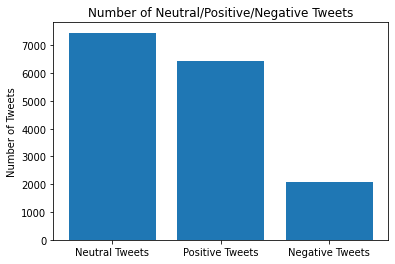

In [143]:
plt.bar(['Neutral Tweets','Positive Tweets','Negative Tweets'], train_data['label'].value_counts())
plt.ylabel("Number of Tweets")
plt.title("Number of Neutral/Positive/Negative Tweets")
plt.show()

**It's clear that most tweets in the training dataset express a neutral opinion on vaccines, a little less tweets express a positive opinion and the least tweets express a negative one. There's certainly an imbalance we should consider.**

In [144]:
def most_used_ngrams(corpus, max_features=30, ngrams=(2, 3), title=''):
  plt.figure(figsize=(min(max_features, 30),3))
  plt.title(title)
  plt.xticks(rotation=45)
  vectorizer = CountVectorizer(ngram_range=ngrams,  max_features=max_features, stop_words='english')
  ngrams = vectorizer.fit_transform(corpus)
  count_sum = ngrams.toarray().sum(axis=0)

  ngram_series = pd.Series(data=count_sum, index=vectorizer.get_feature_names_out()).sort_values(ascending=False)

  plt.bar(ngram_series.index, ngram_series.values)


neutral_tweets = train_data[train_data.label == 0]['tweet'].values
negative_tweets = train_data[train_data.label == 1]['tweet'].values
positive_tweets = train_data[train_data.label == 2]['tweet'].values

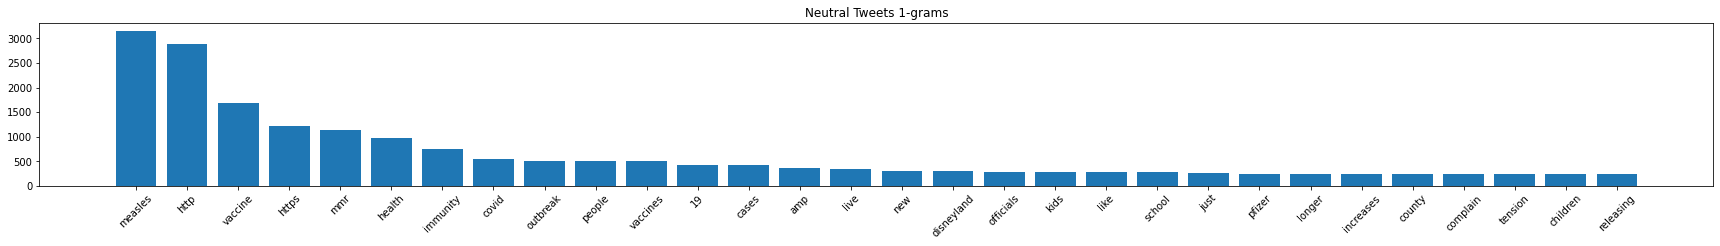

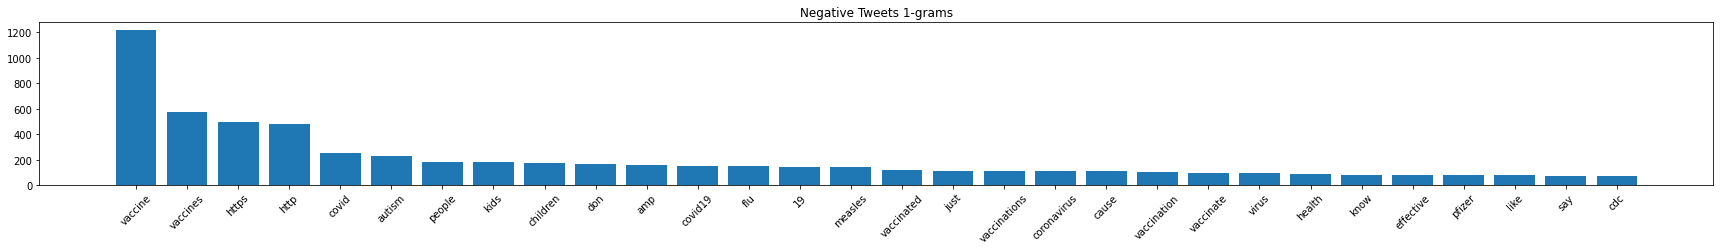

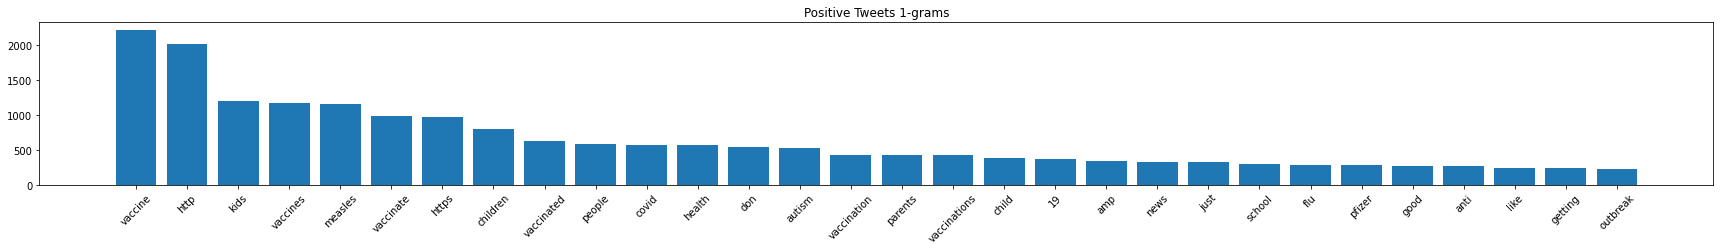

In [145]:
most_used_ngrams(neutral_tweets, title='Neutral Tweets 1-grams', ngrams=(1, 1))
most_used_ngrams(negative_tweets, title='Negative Tweets 1-grams', ngrams=(1, 1))
most_used_ngrams(positive_tweets, title='Positive Tweets 1-grams', ngrams=(1, 1))

**All categories of tweets share same words more or less, making it hard to tell them apart just by 1-grams. Let's try bigrams!**

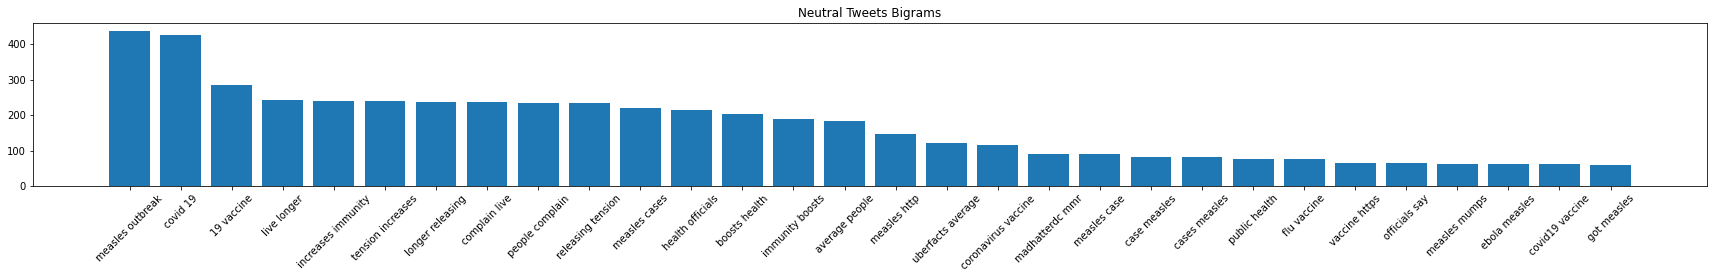

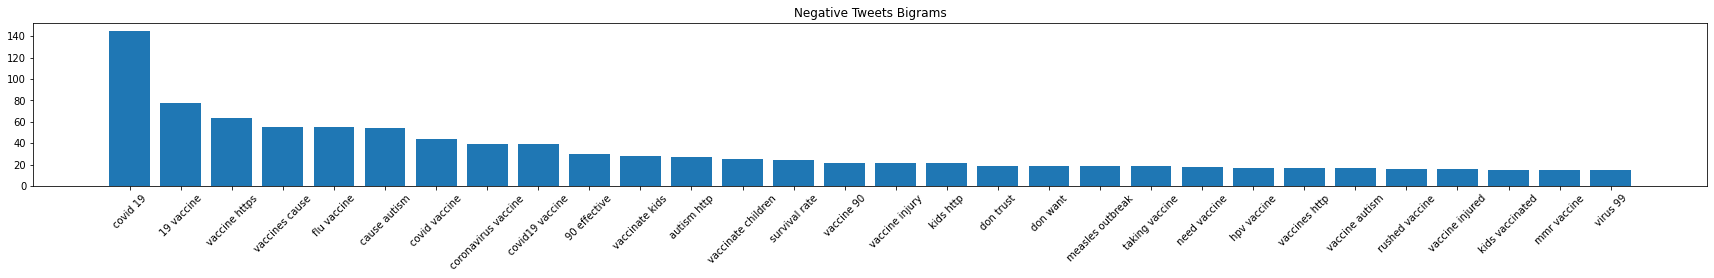

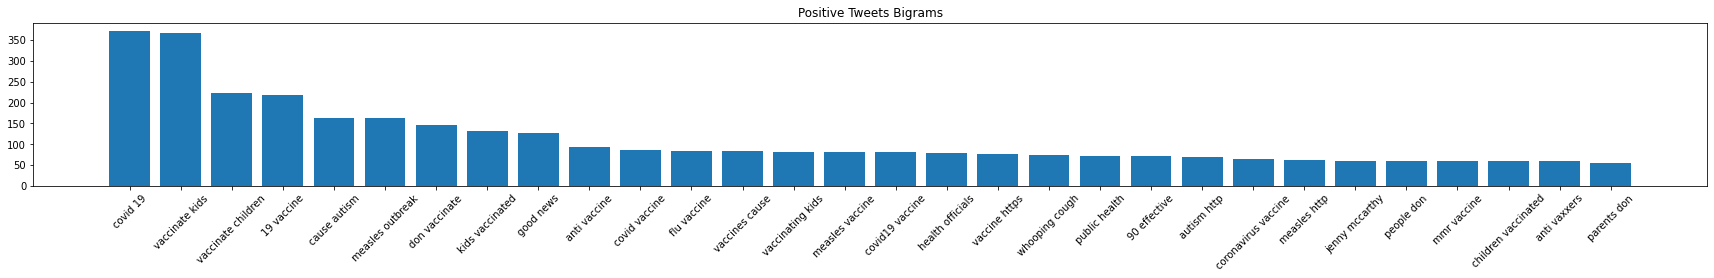

In [146]:
most_used_ngrams(neutral_tweets, title='Neutral Tweets Bigrams', ngrams=(2, 2))
most_used_ngrams(negative_tweets, title='Negative Tweets Bigrams', ngrams=(2, 2))
most_used_ngrams(positive_tweets, title='Positive Tweets Bigrams', ngrams=(2, 2))

**While tweets from all three classes share many bigrams/phrases, it's clear that the neutral tweets have a more even distribution of bigrams. Negative tweets tend to use a lot of phrases mentioning autism (possible as an hypothetical side effect of vaccines).**

In [147]:
def calculate_average_length(corpus):
  lengths = [len(i) for i in corpus]
  return statistics.mean(lengths)

def calculate_median_length(corpus):
  lengths = [len(i) for i in corpus]
  return statistics.median(lengths)

In [148]:
print('Average Neutral Tweets Length: ' + str(calculate_average_length(neutral_tweets)))
print('Average Negative Tweets Length: ' + str(calculate_average_length(negative_tweets)))
print('Average Positive Tweets Length: ' + str(calculate_average_length(positive_tweets)) +'\n')

print('Median Neutral Tweets Length: ' + str(calculate_median_length(neutral_tweets)))
print('Median Negative Tweets Length: ' + str(calculate_median_length(negative_tweets)))
print('Median Positive Tweets Length: ' + str(calculate_median_length(positive_tweets)))

Average Neutral Tweets Length: 116.05805846071333
Average Negative Tweets Length: 142.40665701881332
Average Positive Tweets Length: 126.99379363847945

Median Neutral Tweets Length: 121.0
Median Negative Tweets Length: 134
Median Positive Tweets Length: 128


**The negative tweets tend to be slightly longer while neutral tweets tend to be slightly shorter, but the difference is not that big to justify using it as a seperate feature.**

## **Preprocessing & Vectorization**

In [149]:
def preprocess(text):
  text = text.replace('@', '')
  text = text.replace('#', '')

  return text

def create_vectorizer(train_corpus, method='tf-idf', max_features=20000, ngram_range=(1, 4)):
  if method == 'tf-idf':
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
  elif method == 'bow':
    vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
  return vectorizer.fit(train_corpus)

def vectorize(vectorizer, corpus):
  return vectorizer.transform(corpus)

train_data['tweet'] = train_data['tweet'].apply(preprocess)
validation_data['tweet'] = validation_data['tweet'].apply(preprocess)

train_corpus = train_data['tweet'].tolist()
validation_corpus = validation_data['tweet'].tolist()


vectorizer = create_vectorizer(train_corpus)
train_vector = vectorize(vectorizer, train_corpus)
validation_vector = vectorize(vectorizer, validation_corpus)

x_train = train_vector.toarray()
y_train = train_data['label'].values

x_validation = validation_vector.toarray()
y_validation = validation_data['label'].values

## **Model Creation, Training & Evaluation**

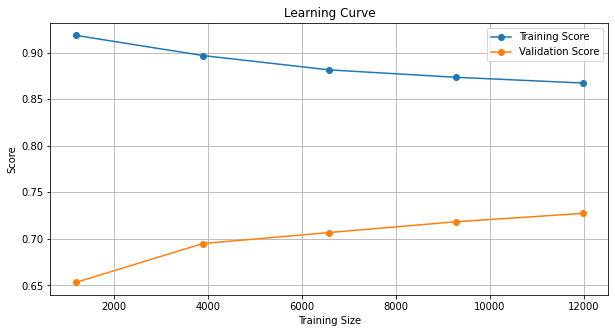

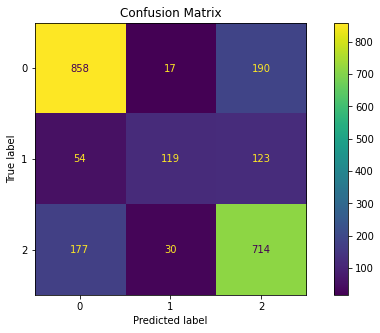

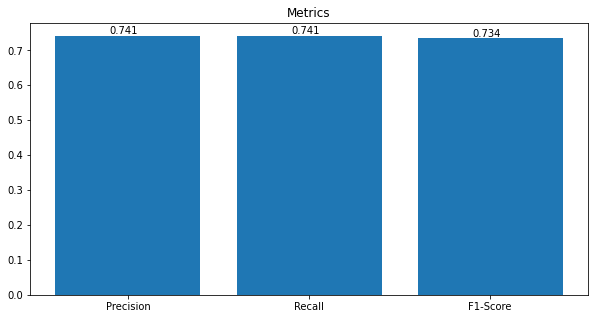

Precision: 0.7412749452512137
Recall: 0.7410166520595969
F1-Score: 0.7344753741665059


In [150]:
classifier = LogisticRegression(multi_class="multinomial", max_iter=1000)
classifier.fit(x_train, y_train)

y_predicted_validation = classifier.predict(x_validation)
precision = precision_score(y_validation, y_predicted_validation, average='weighted')
recall = recall_score(y_validation, y_predicted_validation, average='weighted')
f1 = f1_score(y_validation, y_predicted_validation, average='weighted')

train_sizes, train_scores, test_scores= learning_curve(classifier, x_train, y_train, cv=4)

plt.figure(figsize=(10, 5))
plt.grid(True)
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.plot(train_sizes,np.mean(train_scores,axis=1),  "o-")
plt.plot(train_sizes,np.mean(test_scores,axis=1),  "o-")
plt.legend(['Training Score', 'Validation Score'])
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(classifier, x_validation, y_validation, ax=ax)
plt.show()


plt.figure(figsize=(10, 5))
plt.title('Metrics')
plt.bar(['Precision', 'Recall', 'F1-Score'], [precision, recall, f1])
for index, value in enumerate([precision, recall, f1]):
    plt.text(index-0.1, value+0.005,str(round(value,3)))
plt.show()
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-Score: ' + str(f1))

## **Predictions**

In [177]:
def predict_sentiment(text):
  text = preprocess(text)
  text_vector = vectorize(vectorizer, [text])
  prediction = classifier.predict(text_vector)
  if prediction[0] == 0:
    print('Neutral Sentiment')
  elif prediction[0] == 1:
    print('Negative Sentiment')
  elif prediction[0] == 2:
    print('Positive Sentiment')

predict_sentiment("Vaccines kill people")
predict_sentiment("I am in favour of vaccines, I believe they will help fight coronavirus")
predict_sentiment("Why cannot we just listen to what the scientists say?")
predict_sentiment("I hate anti-vaccinists")
predict_sentiment("I hate vaccines")

Negative Sentiment
Positive Sentiment
Neutral Sentiment
Positive Sentiment
Positive Sentiment
